In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re
import humanize
from datetime import timedelta

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape) # (842663, 112)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(842663, 113)


In [4]:

columns_list = ['scene_type', 'is_scene_aborted', 'is_a_one_triage_file']
frvrs_logs_df[columns_list].drop_duplicates().sort_values(columns_list)

,scene_type,is_scene_aborted,is_a_one_triage_file
56265,Orientation,False,False
0,Orientation,False,True
56267,Triage,False,False
228,Triage,False,True



# Triage Accuracy

(How many patients did they get right and do they do it in the right order, for example: still or obvious life threat first (Red, Gray, Black), then wavers, then walkers last.)


### R-squared

I am using the R-squared value of a linear regression model fit as a measure of how well responders engaged the still first, then wavers, then walkers last. A score of 1.0 will mean that the responder performed the ideal sequence. A score of -1.0 means that the responder performed the opposite sequence.

The algorithm will work for any number of patients. It allows for any number of still patients, which will be correctly placed in the beginning of the ideal sequence. The numbers are just the milliseconds of elapsed time at the engagement of a patient. The scenes are zero-indexed _SESSION_START_ to _SESSION_END_ segments. Time group 1 is the 2nd session in the file, for instance.

This is possibly also a measure of Tolerance for Risk (see https://nextcentury.atlassian.net/wiki/spaces/ITMC/pages/2998960129/KDMAs).

In [37]:

# Create a dataset of measures of right ordering
if nu.pickle_exists('engagment_sort_df'):
    engagment_sort_df = nu.load_object('engagment_sort_df')
else:
    
    # Group the data by session and scene
    import statsmodels.api as sm
    groupby_columns = ['session_uuid', 'scene_index', 'logger_version', 'is_scene_aborted', 'scene_type', 'is_a_one_triage_file']
    gb = frvrs_logs_df.groupby(groupby_columns)
    
    # Iterate over each run to get the data rows
    rows_list = []
    for (session_uuid, scene_index, logger_version, is_scene_aborted, scene_type, is_a_one_triage_file), scene_df in gb:
        row_dict = {}
        
        # Populate the row_dict with values from the groupby_columns
        for cn in groupby_columns: row_dict[cn] = eval(cn)
    
        # Set the last engagement time among all the obvious life threats
        assert ('tag_applied_type' in scene_df.columns)
        mask_series = scene_df.tag_applied_type.isin(['red', 'gray', 'black'])
        df = scene_df[mask_series]
        if df.shape[0]:
            # display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)
            patient_ids_list = df.patient_id.unique().tolist()
            mask_series = True
            for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
            mask_series &= frvrs_logs_df.patient_id.isin(patient_ids_list)
            mask_series &= (frvrs_logs_df.action_type == 'PATIENT_ENGAGED')
            row_dict['last_threat_engaged'] = frvrs_logs_df[mask_series].elapsed_time.max()
    
        # Group the patients by engagement SORT category and get lists of their elapsed times
        engaged_sort_dict = {}
        for sort, patient_engaged_sort_df in scene_df.groupby('patient_engaged_sort'):
            if sort in ['still', 'waver', 'walker']:

                # Get the scene's entire history
                mask_series = True
                for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))

                # Filter by the engaged stills, walkers or wavers
                patient_ids_list = patient_engaged_sort_df.patient_id.unique().tolist()
                mask_series &= frvrs_logs_df.patient_id.isin(patient_ids_list)
                mask_series &= (frvrs_logs_df.action_type == 'PATIENT_ENGAGED')

                # Set the engaged sort stuff
                row_dict[f'last_{sort}_engaged'] = frvrs_logs_df[mask_series].elapsed_time.max()
                engaged_sort_dict[sort] = frvrs_logs_df[mask_series].sort_values(
                    ['elapsed_time']
                ).elapsed_time.tolist()
        
        # Get an R-squared Adjusted as a measure of right ordering
        ideal_sequence = []
        for sort in ['still', 'waver', 'walker']: ideal_sequence.extend(engaged_sort_dict.get(sort, []))
        ideal_sequence = pd.Series(data=ideal_sequence)
        actual_sequence = ideal_sequence.sort_values(ascending=True)
        X, y = ideal_sequence.values.reshape(-1, 1), actual_sequence.values.reshape(-1, 1)
        if X.shape[0]:
            X1 = sm.add_constant(X)
            try: rsquared_adj = sm.OLS(y, X1).fit().rsquared_adj
            except: rsquared_adj = np.nan
            row_dict['rsquared_adj'] = rsquared_adj
        
        rows_list.append(row_dict)
    
    engagment_sort_df = DataFrame(rows_list)
    # nu.store_objects(engagment_sort_df=engagment_sort_df)

In [42]:

# Show the combinations existing in this data frame for the columns
columns_list = ['patient_engaged_sort', 'patient_id']
debug_df[columns_list].drop_duplicates().sort_values(columns_list)

,patient_engaged_sort,patient_id
678057,NaN,Bob_0 Root
165107,NaN,Bob_1 Root
165104,NaN,Bob_10 Root
165083,NaN,Bob_12 Root
165078,NaN,Bob_7 Root
624287,NaN,Bob_9 Root
248870,NaN,Gary_0 Root
678059,NaN,Gary_1 Root
165132,NaN,Gary_16 Root
165109,NaN,Gary_2 Root


In [40]:

# Show the combinations existing in this data frame for the columns
columns_list = ['patient_engaged_sort']
frvrs_logs_df[columns_list].drop_duplicates().sort_values(columns_list)

,patient_engaged_sort
49,still
140,walker
59,waver
0,NaN


In [38]:

debug_df

,action_type,elapsed_time,event_time,session_uuid,file_name,logger_version,scene_index,patient_demoted_health_level,patient_demoted_health_time_remaining,patient_demoted_id,...,player_gaze_patient_id,player_gaze_distance_to_patient,player_gaze_direction_of_gaze,patient_id,location_id,injury_id,voice_capture_sentiment_score,scene_type,is_scene_aborted,is_a_one_triage_file
675784,VOICE_CAPTURE,1238885,2023-05-16 15:19:00,06574b6f-ab02-432c-9a65-7b031218a270,v.1.0/Clean 06574b6f-ab02-432c-9a65-7b031218a2...,1.0,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Orientation,False,False
675785,PATIENT_DEMOTED,1243992,2023-05-16 15:19:00,06574b6f-ab02-432c-9a65-7b031218a270,v.1.0/Clean 06574b6f-ab02-432c-9a65-7b031218a2...,1.0,3,100,Infinity,Mike_1 Root,...,NaN,NaN,NaN,Mike_1 Root,"(2.7, 0.0, 0.1)",NaN,NaN,Orientation,False,False
675786,PATIENT_DEMOTED,1244644,2023-05-16 15:19:00,06574b6f-ab02-432c-9a65-7b031218a270,v.1.0/Clean 06574b6f-ab02-432c-9a65-7b031218a2...,1.0,3,100,Infinity,Mike_2 Root,...,NaN,NaN,NaN,Mike_2 Root,"(2.6, 0.0, 2.4)",NaN,NaN,Orientation,False,False
675787,PATIENT_DEMOTED,1245315,2023-05-16 15:19:00,06574b6f-ab02-432c-9a65-7b031218a270,v.1.0/Clean 06574b6f-ab02-432c-9a65-7b031218a2...,1.0,3,100,128,Mike_3 Root,...,NaN,NaN,NaN,Mike_3 Root,"(3.0, 0.0, 4.3)",NaN,NaN,Orientation,False,False
675788,INJURY_RECORD,1253706,2023-05-16 15:20:00,06574b6f-ab02-432c-9a65-7b031218a270,v.1.0/Clean 06574b6f-ab02-432c-9a65-7b031218a2...,1.0,3,NaN,NaN,NaN,...,NaN,NaN,NaN,Mike_3 Root,"(0.0, 0.0, 0.0)",R Chest Collapse,NaN,Orientation,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723958,TELEPORT,1141274,2023-03-03 13:39:00,e8cb6ae0-6d68-410f-88fc-4adf30d8bfac,v.1.0/Clean Marty8.csv,1.0,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"(1.0, 0.0, 19.3)",NaN,NaN,Triage,False,False
723959,SESSION_END,1148232,2023-03-03 13:40:00,e8cb6ae0-6d68-410f-88fc-4adf30d8bfac,v.1.0/Clean Marty8.csv,1.0,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Triage,False,False
209599,SESSION_END,644284,2023-08-08 11:20:29,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,DCEMS Round 2 only triage sessions/ffecd29f-eb...,1.3,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Orientation,False,True
209600,SESSION_END,645237,2023-08-08 11:20:29,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,DCEMS Round 2 only triage sessions/ffecd29f-eb...,1.3,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Orientation,False,True


In [34]:

# Display a sample of the data frame, dropping columns with all NaN values and transposing it
mask_series = engagment_sort_df.rsquared_adj.isnull()
df = engagment_sort_df[mask_series]
display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)

,443,429,73,606
session_uuid,a0987257-801e-44c5-a1ad-81e0083bfa46,9a6d2f32-10fb-40ea-bacc-dd6a7d2f4a13,158e6365-673b-4030-8b36-6704be5996a2,deecd930-56c6-4679-87d8-7d6627631934
scene_index,1,0,0,0
logger_version,1.0,1.3,1.0,1.0
is_scene_aborted,False,False,False,False
scene_type,Orientation,Triage,Triage,Orientation
is_a_one_triage_file,False,False,True,True
last_walker_engaged,537303.0,33727.0,NaN,NaN
last_waver_engaged,553968.0,NaN,NaN,NaN


In [8]:

columns_list = ['is_scene_aborted', 'is_a_one_triage_file']
nu.get_minority_combinations(engagment_sort_df, columns_list)

,session_uuid,scene_index,logger_version,is_scene_aborted,scene_type,is_a_one_triage_file,last_threat_engaged,last_walker_engaged,rsquared_adj,last_still_engaged,last_waver_engaged
253,5c720560-85f5-4bb1-9aa5-41207f6259a2,0,1.3,False,Triage,False,18071.0,18071.0,NaN,NaN,NaN
564,d11543fd-7b7f-4883-bd69-afe8128a76f2,0,1.3,False,Triage,True,385787.0,385787.0,0.160679,309234.0,290466.0



Here is a histogram of the values:

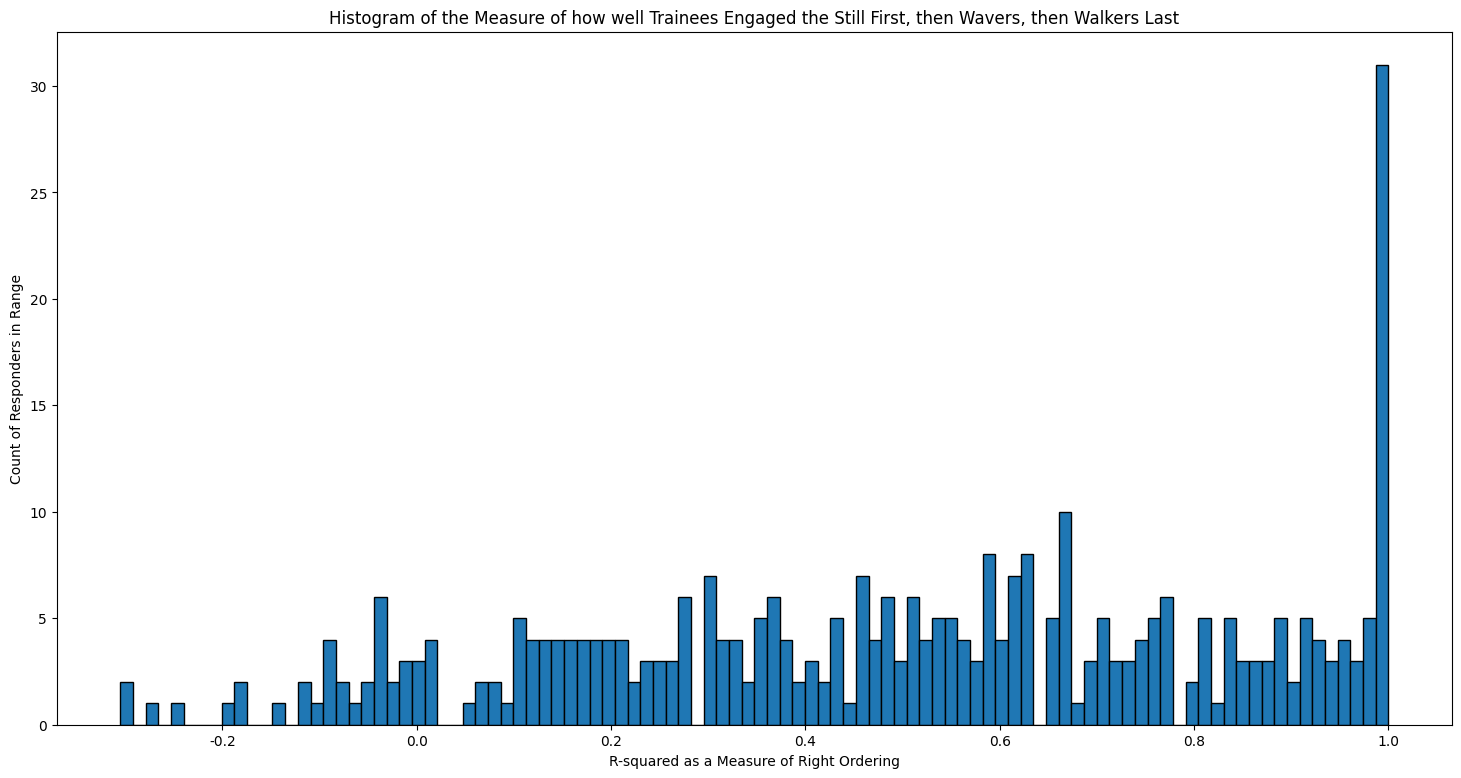

In [10]:

# Display a histogram of the distribution of the measure of
# how well responders engaged the still first, then wavers, then walkers last
xlabel = 'R-squared as a Measure of Right Ordering'
get_xtick_text = lambda text_obj: round(text_obj.get_position()[0], 2)
title = 'Histogram of the Measure of how well Trainees Engaged the Still First, then Wavers, then Walkers Last'
ylabel = 'Count of Responders in Range'
mask_series = (engagment_sort_df.scene_type == 'Triage') & (engagment_sort_df.is_scene_aborted == False) & (engagment_sort_df.is_a_one_triage_file == True)
ax = nu.plot_histogram(engagment_sort_df[mask_series], 'rsquared_adj', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title, ylabel=ylabel, xticks_are_temporal=False)

In [29]:

# Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
mask_series = (engagment_sort_df.scene_type == 'Triage') & (engagment_sort_df.is_scene_aborted == False) & (engagment_sort_df.is_a_one_triage_file == True)
columns_list = [
    'rsquared_adj'
]
df = engagment_sort_df[mask_series][columns_list]
display(nu.get_statistics(df, columns_list).applymap(lambda x: round(x, 1), na_action='ignore').T)

,mean,mode,median,SD,min,25%,50%,75%,max
rsquared_adj,0.5,1.0,0.5,0.3,-0.3,0.2,0.5,0.8,1.0


In [30]:

mask_series = (engagment_sort_df.scene_type == 'Triage') & (engagment_sort_df.is_scene_aborted == False) & (engagment_sort_df.is_a_one_triage_file == True)
df = engagment_sort_df[mask_series]
srs = df.value_counts(subset=['rsquared_adj'])
display(srs)
print(100*srs.iloc[0]/srs.size)

rsquared_adj
1.000000        24
0.720739         1
0.654510         1
0.652565         1
0.650533         1
                ..
0.317747         1
0.312984         1
0.307318         1
0.306172         1
0.493902         1
Name: count, Length: 323, dtype: int64

7.430340557275541


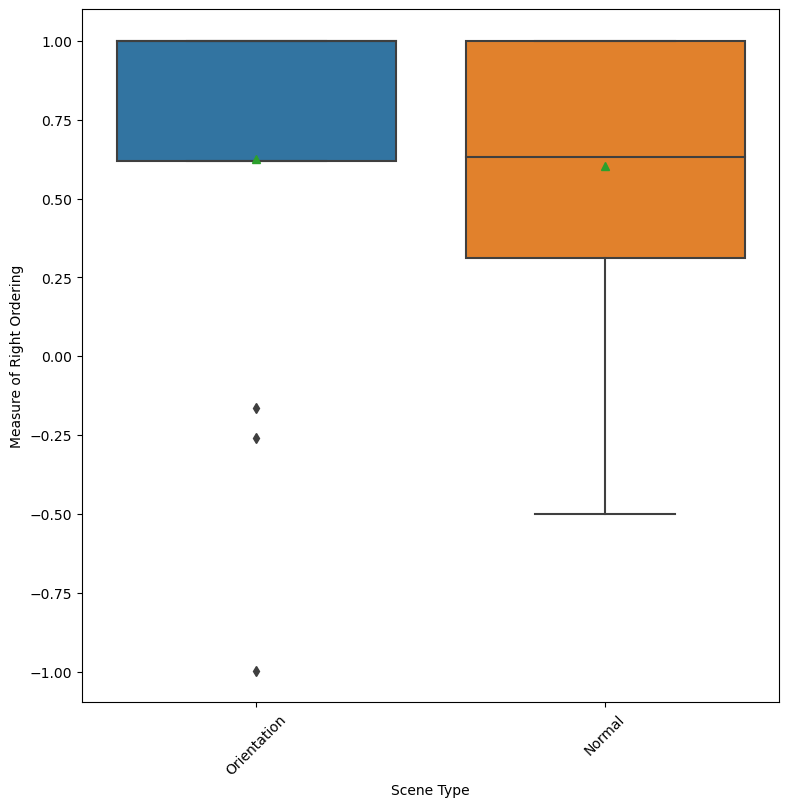

In [8]:

# Filter out anything after 16 minutes per Nicholas Kman
mask_series = (engagment_sort_df.is_scene_aborted == False)
df = engagment_sort_df[mask_series]
nu.plot_grouped_box_and_whiskers(df, 'scene_type', 'rsquared_adj', 'Scene Type', 'Measure of Right Ordering', transformer_name=None, is_y_temporal=False)

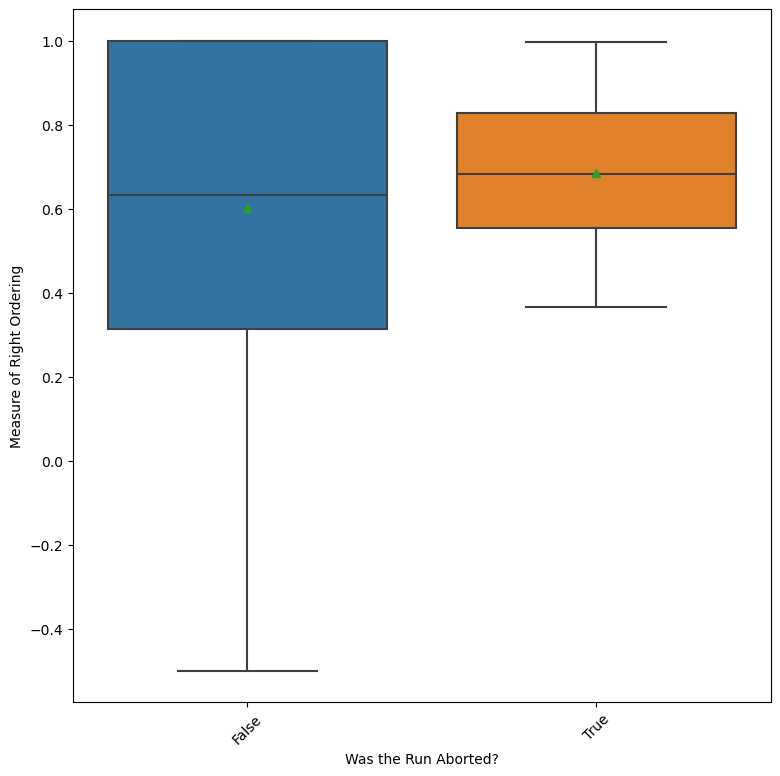

In [9]:

mask_series = (engagment_sort_df.scene_type == 'Triage')
df = engagment_sort_df[mask_series]
nu.plot_grouped_box_and_whiskers(df, 'is_scene_aborted', 'rsquared_adj', 'Was the Run Aborted?', 'Measure of Right Ordering', transformer_name=None, is_y_temporal=False)


## How many responders did the right order? Should be a percentage of all responders


In [10]:

mask_series = (engagment_sort_df.scene_type == 'Triage') & (engagment_sort_df.is_scene_aborted == False)
total_count = engagment_sort_df[mask_series].shape[0]
mask_series &= (engagment_sort_df.rsquared_adj == 1.0)
correct_count = engagment_sort_df[mask_series].shape[0]
percentage_tag_correct = 100*correct_count/total_count
print(f'{percentage_tag_correct:.2f}% of non-orientation, not-scene-aborted responders engaged the still first, then wavers, then walkers last, in an ideal sequence.')

19.28% of non-orientation, not-scene-aborted responders engaged the still first, then wavers, then walkers last, in an ideal sequence.
